In [ ]:
! pip install pandas numpy tensorflow scikit-learn imbalanced-learn matplotlib seaborn

In [13]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [16]:
# ==========================================
# 1. Configuration
# ==========================================
# Data Settings
DATA_PATH = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/aligned_wrist_data_64Hz_v1.csv'
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(os.getcwd(), 'aligned_wrist_data_64Hz_v1.csv')

WINDOW_SIZE_SEC = 30       # 30-second windows (shorter = more windows, esp. with sparse labels)
SAMPLING_RATE = 64         # 64 Hz
WINDOW_LENGTH = WINDOW_SIZE_SEC * SAMPLING_RATE  # 1920 samples
STRIDE = WINDOW_LENGTH // 2  # 50% Overlap

# Window label threshold: require at least this fraction of non-(-1) labels (0.2 = 20%)
# Lower = more windows but noisier; higher = fewer but purer windows
MIN_VALID_LABEL_RATIO = 0.2

# Classification: 'binary' = stress vs non-stress (0,1), '3class' = baseline/stress/amusement (0,1,2)
N_CLASSES = 2  # 2 = binary, 3 = 3-class

# Training Settings
BATCH_SIZE = 16            # Smaller batch for limited data
EPOCHS = 80                # Use early stopping; max epochs
LEARNING_RATE = 0.001
USE_CLASS_WEIGHTS = True   # Handle class imbalance
USE_OVERSAMPLING = True    # Oversample minority class when possible

# Early Stopping
EARLY_STOPPING_PATIENCE = 15

# Deep supervision: auxiliary classification heads at intermediate layers (improves gradient flow)
USE_DEEP_SUPERVISION = False   # Set True for multi-output; False for single output (class_weight works)
AUX_LOSS_WEIGHT = 0.4   # weight for each auxiliary head (main head = 1.0)

# The 11/2/2 Split (Hardcoded for reproducibility)
TRAIN_SUBJECTS = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13']
VAL_SUBJECTS   = ['S14', 'S15']
TEST_SUBJECTS  = ['S16', 'S17']

In [17]:
# ==========================================
# 2. Data Loading & Labeling
# ==========================================
def load_and_label_data(filepath):
    """
    Loads aligned BVP/EDA data. Uses real labels if 'label' column exists
    (0=baseline, 1=stress, 2=amusement, -1=other). Otherwise generates fallback labels.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}\n(Unzip aligned_wrist_data_64Hz.csv.zip if needed)")
    print("Loading data...")
    df = pd.read_csv(filepath)

    if 'label' in df.columns:
        print("Using real labels from CSV. Distribution:")
        print(df['label'].value_counts().sort_index())
        # Ensure int type
        df['label'] = df['label'].astype(int)
    else:
        print("No 'label' column found. Using fallback (first half=baseline, second half=stress)...")
        df['label'] = 0
        for sub in df['subject'].unique():
            sub_mask = df['subject'] == sub
            max_time = df.loc[sub_mask, 'time_sec'].max()
            df.loc[sub_mask & (df['time_sec'] > max_time / 2), 'label'] = 1

    return df


In [19]:
# ==========================================
# 3. Preprocessing (Normalization & Windowing)
# ==========================================
def _window_label(window_labels, n_classes, min_valid_ratio=0.2):
    """
    Majority vote for window. For 2-class: 0,2->0 (non-stress), 1->1 (stress).
    Skip windows where fewer than min_valid_ratio of samples have valid labels (non -1).
    """
    valid = window_labels[window_labels >= 0]  # exclude -1
    if len(valid) < len(window_labels) * min_valid_ratio:
        return None
    if n_classes == 2:
        # Map 2 (amusement) -> 0 (non-stress)
        valid = np.where(valid == 2, 0, valid)
        valid = valid[valid <= 1]  # keep only 0,1
        if len(valid) == 0:
            return None
    counts = np.bincount(valid.astype(int), minlength=n_classes)
    return int(np.argmax(counts))

def create_windows(df, subjects, n_classes=2, min_valid_ratio=None):
    """
    Slices data into fixed-length windows. Normalizes per subject (Z-Score).
    For 2-class: 0=non-stress (baseline+amusement), 1=stress.
    """
    if min_valid_ratio is None:
        min_valid_ratio = MIN_VALID_LABEL_RATIO
    X_windows, y_windows = [], []

    for sub in subjects:
        sub_df = df[df['subject'] == sub].copy()
        if sub_df.empty:
            continue

        scaler = StandardScaler()
        sub_df[['bvp', 'eda']] = scaler.fit_transform(sub_df[['bvp', 'eda']])
        data_arr = sub_df[['bvp', 'eda']].values
        label_arr = sub_df['label'].values
        num_samples = len(data_arr)

        for start in range(0, num_samples - WINDOW_LENGTH, STRIDE):
            end = start + WINDOW_LENGTH
            window_data = data_arr[start:end]
            window_labels = label_arr[start:end]
            lbl = _window_label(window_labels, n_classes, min_valid_ratio)
            if lbl is not None:
                X_windows.append(window_data)
                y_windows.append(lbl)

    return np.array(X_windows) if X_windows else np.array([]).reshape(0, WINDOW_LENGTH, 2), \
           np.array(y_windows) if y_windows else np.array([])

In [20]:
# ==========================================
# 4. Model Architecture (1D-CNN with optional Deep Supervision)
# ==========================================
def build_1d_cnn(input_shape, n_classes=2, use_deep_supervision=False, aux_loss_weight=0.4):
    """
    1D-CNN for BVP/EDA. With deep supervision: auxiliary classification heads at
    intermediate layers (after conv block 1 and 2) to improve gradient flow.
    """
    inputs = layers.Input(shape=input_shape)

    k1 = min(64, input_shape[0] // 30)
    k2 = min(32, input_shape[0] // 60)
    k3 = min(16, input_shape[0] // 120)

    # Block 1
    x = layers.Conv1D(filters=32, kernel_size=k1, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=4)(x)
    x = layers.Dropout(0.2)(x)
    h1 = x  # for deep supervision

    # Block 2
    x = layers.Conv1D(filters=64, kernel_size=k2, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=4)(x)
    x = layers.Dropout(0.2)(x)
    h2 = x  # for deep supervision

    # Block 3 + main head
    x = layers.Conv1D(filters=128, kernel_size=k3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    main_out = layers.Dense(n_classes, activation='softmax', name='main')(x)

    if use_deep_supervision:
        # Auxiliary head 1 (from block 1)
        a1 = layers.GlobalAveragePooling1D()(h1)
        a1 = layers.Dense(32, activation='relu')(a1)
        a1 = layers.Dropout(0.3)(a1)
        aux1_out = layers.Dense(n_classes, activation='softmax', name='aux1')(a1)
        # Auxiliary head 2 (from block 2)
        a2 = layers.GlobalAveragePooling1D()(h2)
        a2 = layers.Dense(32, activation='relu')(a2)
        a2 = layers.Dropout(0.3)(a2)
        aux2_out = layers.Dense(n_classes, activation='softmax', name='aux2')(a2)
        outputs = [main_out, aux1_out, aux2_out]
        loss_weights = [1.0, aux_loss_weight, aux_loss_weight]
    else:
        outputs = main_out
        loss_weights = None

    model = models.Model(inputs=inputs, outputs=outputs)
    loss = 'sparse_categorical_crossentropy'
    if use_deep_supervision:
        model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss=[loss] * 3, loss_weights=loss_weights, metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss=loss, metrics=['accuracy'])
    return model

In [21]:
# ==========================================
# 5. Main Execution Pipeline
# ==========================================
# A. Load Data
df = load_and_label_data(DATA_PATH)

# B. Create Datasets (Train / Val / Test)
print(f"\nCreating windows ({WINDOW_SIZE_SEC}s, {N_CLASSES}-class, min_valid_ratio={MIN_VALID_LABEL_RATIO})...")
X_train, y_train = create_windows(df, TRAIN_SUBJECTS, n_classes=N_CLASSES)
X_val, y_val     = create_windows(df, VAL_SUBJECTS, n_classes=N_CLASSES)
X_test, y_test   = create_windows(df, TEST_SUBJECTS, n_classes=N_CLASSES)

print(f"Train Shape: {X_train.shape} (Subjects: {len(TRAIN_SUBJECTS)})")
print(f"Val Shape:   {X_val.shape}   (Subjects: {len(VAL_SUBJECTS)})")
print(f"Test Shape:  {X_test.shape}  (Subjects: {len(TEST_SUBJECTS)})")
class_names = ['non-stress', 'stress'] if N_CLASSES == 2 else ['baseline', 'stress', 'amusement']

if len(X_train) == 0:
    raise ValueError("No training windows generated. Try lowering MIN_VALID_LABEL_RATIO or check subject split.")
train_counts = np.bincount(y_train.astype(int), minlength=N_CLASSES)
print(f"Train class distribution: {dict(zip(class_names, train_counts))}")

# Check for missing classes
missing = [c for c in range(N_CLASSES) if train_counts[c] == 0]
if missing:
    print(f"\n⚠️  Warning: No training samples for class(es) {missing}. Model cannot learn these classes.")
    print("   Consider: lowering MIN_VALID_LABEL_RATIO, using different subject split, or 3-class mode.")

# C. Class Weights & Oversampling
class_weight = None
if USE_CLASS_WEIGHTS and len(np.unique(y_train)) > 1:
    cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight = dict(zip(np.unique(y_train), cw))
    print(f"\nClass weights (for imbalance): {class_weight}")

if USE_OVERSAMPLING and len(X_train) > 0 and len(np.unique(y_train)) > 1:
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    n_samples, n_timesteps, n_features = X_train.shape
    X_flat = X_train.reshape(n_samples, -1)
    X_flat, y_train = ros.fit_resample(X_flat, y_train)
    X_train = X_flat.reshape(-1, n_timesteps, n_features)
    print(f"After oversampling - Train shape: {X_train.shape}, class dist: {np.bincount(y_train.astype(int))}")

# D. Build Model & Callbacks
input_shape = (WINDOW_LENGTH, 2)
model = build_1d_cnn(input_shape, n_classes=N_CLASSES,
              use_deep_supervision=USE_DEEP_SUPERVISION, aux_loss_weight=AUX_LOSS_WEIGHT)
model.summary()

save_path = os.path.join(os.path.dirname(DATA_PATH), 'wesad_1d_cnn_best.keras')
has_val = len(X_val) > 0
monitor = 'val_loss' if has_val else 'loss'
cb = [
    callbacks.EarlyStopping(
        monitor=monitor, patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1
    ),
    callbacks.ModelCheckpoint(save_path, monitor=monitor, save_best_only=True, verbose=0)
]

# E. Train (deep supervision uses same labels for main + auxiliary heads)
if USE_DEEP_SUPERVISION:
    y_train_fit = [y_train, y_train, y_train]
    val_data = (X_val, [y_val, y_val, y_val]) if has_val else None
    # Keras does not support class_weight for multi-output models; rely on oversampling for imbalance
    class_weight_fit = None
else:
    y_train_fit, val_data = y_train, (X_val, y_val) if has_val else None
    class_weight_fit = class_weight
print("\nStarting Training...")
history = model.fit(
    X_train, y_train_fit,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=min(BATCH_SIZE, len(X_train)),
    class_weight=class_weight_fit,
    callbacks=cb,
    verbose=1
)

# F. Final Evaluation (main head only for metrics)
print("\nEvaluating on Test Set (Unseen Subjects)...")
if len(X_test) > 0:
    y_test_eval = [y_test, y_test, y_test] if USE_DEEP_SUPERVISION else y_test
    eval_result = model.evaluate(X_test, y_test_eval)
    test_loss = eval_result[0]
    test_acc = eval_result[1][0] if isinstance(eval_result[1], list) else eval_result[1]
    print(f"Test Accuracy (main head): {test_acc:.4f}")

    preds = model.predict(X_test, verbose=0)
    y_pred = np.argmax(preds[0], axis=1) if USE_DEEP_SUPERVISION else np.argmax(preds, axis=1)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Test Balanced Accuracy: {bal_acc:.4f} (better metric for imbalanced data)")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, labels=range(N_CLASSES), target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred, labels=range(N_CLASSES)))
else:
    print("No test samples. Skipping evaluation.")

final_path = os.path.join(os.path.dirname(DATA_PATH), 'wesad_1d_cnn.keras')
model.save(final_path)
print(f"\nModel saved to {final_path}")

Loading data...
Using real labels from CSV. Distribution:
label
-1    3387163
 0    1147053
 1     655346
 2     369990
Name: count, dtype: int64

Creating windows (30s, 2-class, min_valid_ratio=0.2)...
Train Shape: (1691, 1920, 2) (Subjects: 11)
Val Shape:   (309, 1920, 2)   (Subjects: 2)
Test Shape:  (314, 1920, 2)  (Subjects: 2)
Train class distribution: {'non-stress': np.int64(1183), 'stress': np.int64(508)}

Class weights (for imbalance): {np.int64(0): np.float64(0.7147083685545224), np.int64(1): np.float64(1.6643700787401574)}
After oversampling - Train shape: (2366, 1920, 2), class dist: [1183 1183]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1920, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1920, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 480, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 480, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 480, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 120, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main (Dense)                    │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,330 (825.51 KB)

 Trainable params: 211,330 (825.51 KB)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9184 - loss: 0.2320 - val_accuracy: 0.9256 - val_loss: 0.1457
Epoch 2/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9332 - loss: 0.1930 - val_accuracy: 0.8932 - val_loss: 0.1644
Epoch 3/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9493 - loss: 0.1390 - val_accuracy: 0.8835 - val_loss: 0.2265
Epoch 4/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9438 - loss: 0.1709 - val_accuracy: 0.8770 - val_loss: 0.1844
Epoch 5/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9560 - loss: 0.1152 - val_accuracy: 0.8835 - val_loss: 0.1766
Epoch 6/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9582 - loss: 0.1115 - val_accuracy: 0.9029 - val_loss: 0.1461
Epoch 7/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9565 - loss: 0.1064 - val_accuracy: 0.8964 - val_loss: 0.1515
Epoch 8/80
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9565 - l

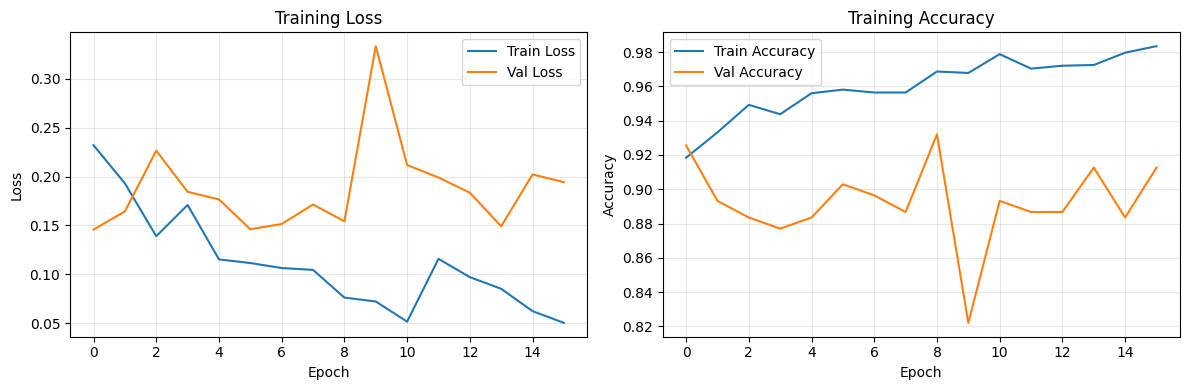

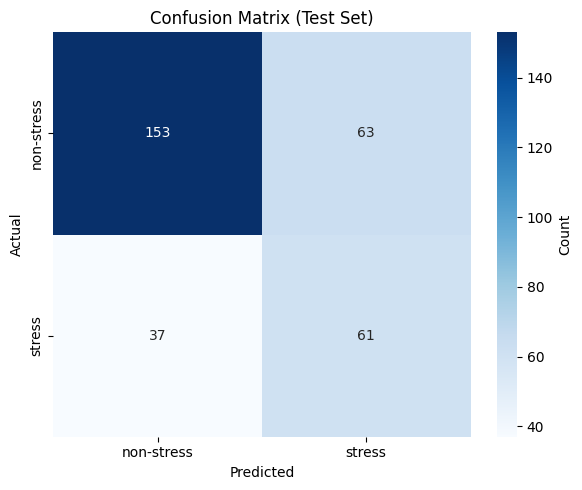


RESULTS SUMMARY
Test Accuracy:        0.6815
Balanced Accuracy:    0.6654
Weighted Precision:   0.7075
Weighted Recall:      0.6815
Weighted F1-Score:    0.6900


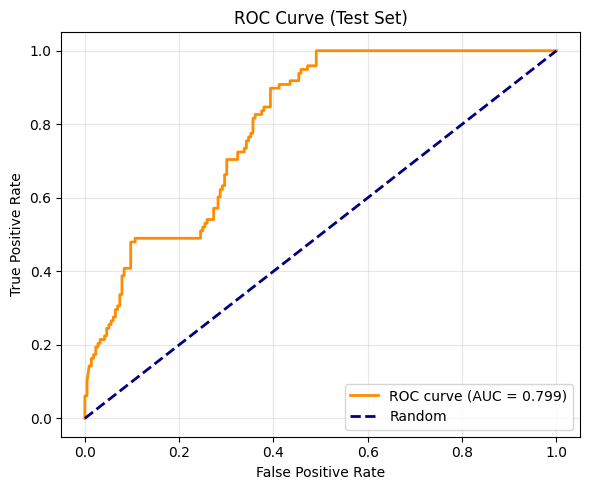

In [22]:
# ==========================================
# 6. Visualize Results
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Training History (Loss & Accuracy)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Confusion Matrix Heatmap (on Test Set)
if len(X_test) > 0:
    preds = model.predict(X_test, verbose=0)
    y_pred = np.argmax(preds[0], axis=1) if USE_DEEP_SUPERVISION else np.argmax(preds, axis=1)
    cm = confusion_matrix(y_test, y_pred, labels=range(N_CLASSES))
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()

    # 3. Summary Metrics
    from sklearn.metrics import precision_recall_fscore_support
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    print(f"Test Accuracy:        {test_acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Weighted Precision:   {prec:.4f}")
    print(f"Weighted Recall:      {rec:.4f}")
    print(f"Weighted F1-Score:    {f1:.4f}")
    print("="*50)

    # 4. ROC Curve (binary classification)
    if N_CLASSES == 2:
        from sklearn.metrics import roc_curve, roc_auc_score
        p = model.predict(X_test, verbose=0)
        y_proba = (p[0][:, 1] if USE_DEEP_SUPERVISION else p[:, 1])  # P(stress) from main head
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve (Test Set)')
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()